# Init

In [18]:
import numpy as np
from utils import *
from skfem.helpers import *
from scipy.sparse.linalg import LinearOperator, minres, cg
from skfem.assembly import BilinearForm, LinearForm
import datetime
import pandas as pd
from skfem.visuals.matplotlib import draw, plot
import sys
import time

tol = 1e-8
intorder = 5
solver_type = 'mgcg'
refine_time = 5
epsilon_range = 6
element_type = 'P1'
sigma = 5
penalty = False
# epsilon = 1e-5
example = 'ex4'
save_path = 'log/' + example + '_' + element_type + '_' + ('pen' if penalty else 'nopen') + '_' +'{}'.format(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

# def dirichlet(w):
#     """return a harmonic function"""
#     x, y = w
#     theta = arctan3(y, x)
#     return (x**2 + y**2)**(5/6) * sin(5*theta/3)

def solve_problem1(m, element_type='P1', solver_type='pcg', intorder=6, tol=1e-8, epsilon=1e-6):
    '''
    switching to mgcg solver for problem 1
    '''
    if element_type == 'P1':
        element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
    elif element_type == 'P2':
        element = {'w': ElementTriP2(), 'u': ElementTriMorley()}
    else:
        raise Exception("Element not supported")

    basis = {
        variable: InteriorBasis(m, e, intorder=intorder)
        for variable, e in element.items()
    }
    
    K1 = asm(laplace, basis['w'])
    f1 = asm(f_load, basis['w'])
    wh = solve(*condense(K1, f1, D=basis['w'].find_dofs()), solver=solver_iter_mgcg(tol=tol))
    
    global K2, f2, uh0, boundary_dofs, boundary_dofs_un, boundary_dofs_u
    
    
    K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
    f2 = asm(wv_load, basis['w'], basis['u']) * wh
    
    boundary_dofs = basis['u'].find_dofs()['all'].all()
#     print(boundary_dofs)
    boundary_dofs_u = np.array([i for i in boundary_dofs if i in basis['u'].nodal_dofs[0]])
    boundary_dofs_un = np.array([i for i in boundary_dofs if i in basis['u'].facet_dofs[0]])
#     print(boundary_dofs_u)
#     print(boundary_dofs_un)
    uh0 = np.zeros(basis['u'].N)
    uh0[boundary_dofs_u] = exact_u(basis['u'].doflocs[0][boundary_dofs_u], basis['u'].doflocs[1][boundary_dofs_u])
#     print(uh0[boundary_dofs_u])
    uh0[boundary_dofs_un] = exact_un(basis['u'].doflocs[0][boundary_dofs_un], basis['u'].doflocs[1][boundary_dofs_un])
#     print(uh0[boundary_dofs_un])
    # * h maybe 
#     print('Before solving: ', uh0)
    uh0 = solve(*condense(K2, f2, uh0, D=boundary_dofs), solver=solver_iter_mgcg(tol=tol))
#     print('After solving: ', uh0)
    return uh0, basis

In [ ]:
basis['u'].dofs.nodal_dofs

# Solving

In [19]:
# def exact_u(x, y):
#     return (x**2*(x - 1)**2 + 1)*(y**2*(y - 1)**2 + 2)

# def dexact_u(x, y):
#     dux = (y**2*(y - 1)**2 + 2)*(2*x*(x - 1)**2 + x**2*(2*x - 2))
#     duy = (x**2*(x - 1)**2 + 1)*(2*y*(y - 1)**2 + y**2*(2*y - 2))
#     return dux, duy

def exact_un(x, y):
#     nx = -1 * (x == -1) + 1 * ((x == 1) + (x == 0) * (y > 0))
#     ny = -1 * (y == -1) + 1 * ((y == 1) + (y == 0) * (x > 0))
    nx = -1 * (x == 0) + 1 * (x == 1)
    ny = -1 * (y == 0) + 1 * (y == 1)
#     print(nx)
#     print(ny)
    dux, duy = dexact_u(x, y)
    out = nx * dux + ny * duy
    return out

# @LinearForm
# def f_load(v, w):
#     '''
#     for $(f, x_{h})$
#     '''
#     x, y = w.x
#     # lu = 0
#     # llu = 0
#     # return (epsilon**2 * llu - lu) * v
#     return ((24*x**2*(x - 1)**2 + 24*y**2*(y - 1)**2 + 2*(4*x*(2*x - 2) + 2*(x - 1)**2 + 2*x**2)*(4*y*(2*y - 2) + 2*(y - 1)**2 + 2*y**2) + 72)*ep**2 - (y**2*(y - 1)**2 + 2)*(4*x*(2*x - 2) + 2*(x - 1)**2 + 2*x**2) - (x**2*(x - 1)**2 + 1)*(4*y*(2*y - 2) + 2*(y - 1)**2 + 2*y**2)) * v

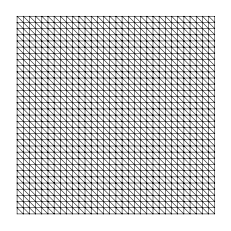

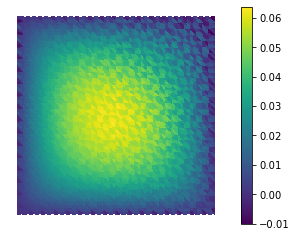

In [21]:
# m = MeshTri().init_lshaped()
m = MeshTri()
# m = MeshTri().init_symmetric()
m.refine(5)
draw(m)

epsilon = 0
ep = epsilon

uh0, basis = solve_problem1(m, element_type, solver_type, intorder, tol, epsilon)

x = basis['u'].doflocs[0]
y = basis['u'].doflocs[1]
u = exact_u(x, y)
# u[boundary_dofs_un] = exact_un(basis['u'].doflocs[0][boundary_dofs_un], basis['u'].doflocs[1][boundary_dofs_un])
plot(basis['u'], u-uh0, colorbar=True)
# plot(basis['u'], uh0, colorbar=True)

In [ ]:
x = boundary_basis.doflocs[0][boundary_dofs_un]
y = boundary_basis.doflocs[1][boundary_dofs_un]

In [ ]:
u

In [ ]:
uh0

In [ ]:
x

In [ ]:
y

In [ ]:
# basis['u'].doflocs

# # basis['u'].nodal_dofs[0]
# for i in range(25):
# #     print(i)
# #     print(boundary_basis.doflocs[:, i])
#     pass

# basis['u'].find_dofs()['all'].all()

# np.array([i for i in basis['u'].find_dofs()['all'].all() if i in basis['u'].nodal_dofs[0]])

# basis['u'].facet_dofs[0]

# uh0


# np.arctan2(1, 0)

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
x = np.arange(-1, 1, 0.05)
y = np.arange(-1, 1, 0.05)
X, Y = np.meshgrid(x, y) 
Z = exact_u(X, Y)
plt.xlabel('x')
plt.ylabel('y')

ax.plot_surface(X, Y, Z, rstride=2, cstride=1, cmap='rainbow')
plt.show()

# boundary_dofs

# easy_boundary(m, basis['u'])
# np.hstack([boundary_dofs, easy_boundary(m, basis['u'])])

In [ ]:
boundary_basis.find_dofs()['all'].all()

In [ ]:
# v.value

In [ ]:
# (w.n[0] * u_x + w.n[1] * u_y) * v

In [ ]:
boundary_basis.find_dofs()['all'].all()

In [ ]:
basis['u'].nodal_dofs[0]

In [ ]:
basis['u'].facet_dofs[0]

In [ ]:
uh0.shape

boundary_dofs.shape

basis['u'].facet_dofs

basis['u'].nodal_dofs[0]

basis['u'].get_dofs()

basis['u'].find_dofs()['all'].all()

pproject(dirichlet, basis_to=boundary_basis, I=boundary_dofs, solver=minres)

exact_u(boundary_basis.doflocs[0][boundary_dofs], boundary_basis.doflocs[1][boundary_dofs])

boundary_dofs

In [ ]:
plot(basis['u'], u, colorbar=True)

In [ ]:
plot(basis['u'], uh0, colorbar=True)

In [ ]:
# w = www
# v = vvv
# x, y = w.x
# u_x, u_y = dexact_u(x, y)
# (w.n[0] * u_x + w.n[1] * u_y) * v

In [ ]:
exact_u(x, y)

In [ ]:
dirichlet([x, y])

In [ ]:
exact_u(np.array([-0.00000]), np.array([0.8]))

In [ ]:
dirichlet([np.array([[-0.00000]]), np.array([[0.8]])])

In [ ]:
boundary_basis.mesh

In [ ]:
exact_u(boundary_basis.doflocs[0], boundary_basis.doflocs[1])

In [ ]:
pproject(dirichlet, basis_to=boundary_basis, I=boundary_dofs, solver=minres)

In [ ]:
(uh0 - u)[:30]

In [ ]:
u

In [ ]:
time_start = time.time()

print('=======Arguments=======')
print('penalty:\t{}'.format(penalty))
print('element_type:\t{}'.format(element_type))
print('solver_type:\t{}'.format(solver_type))
print('tol:\t{}'.format(tol))
print('intorder:\t{}'.format(intorder))
print('refine_time:\t{}'.format(refine_time))
print('sigma:\t{}'.format(sigma))
print('=======Results=======')

df_list = []
for j in range(epsilon_range):
    epsilon = 1 * 10**(-j)
    ep = epsilon
    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
#     m = MeshTri().init_lshaped()
    m = MeshTri()
#     draw(m)

    for i in range(1, refine_time+1):
        
        m.refine()
        
        if penalty:
            uh0, basis, fbasis = solve_problem2(m, element_type, solver_type, intorder, tol, epsilon)
        else:
            uh0, basis = solve_problem1(m, element_type, solver_type, intorder, tol, epsilon)

        U = basis['u'].interpolate(uh0).value

        # compute errors

        L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
        Du = get_DuError(basis['u'], uh0)
        H1u = Du + L2u
        if penalty:
            D2u = np.sqrt(get_D2uError(basis['u'], uh0)**2 + L2pnvError.assemble(fbasis, w=fbasis.interpolate(uh0)))
        else:
            D2u = get_D2uError(basis['u'], uh0)
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)
        
    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    D2us = np.array(D2u_list)
    epus = np.array(epu_list)
    H1s = L2s + Dus
    H2s = H1s + D2us
    
    # store data
    data = np.array([L2s, H1s, H2s, epus])
    df = pd.DataFrame(data.T, columns=['L2', 'H1', 'H2', 'Energy'])
    df_list.append(df)
    
    print('epsilion:', epsilon)
    show_result(L2s, H1s, H2s, epus)

time_end = time.time()

result = df_list[0].append(df_list[1:])
# result.to_csv(save_path+'.csv')
print('======= Errors saved in:', save_path+'.csv ==========')
print('Total Time Cost {:.2f} s'.format(time_end-time_start))